## Building Chatbot

### Import Packages

In [1]:

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import List, Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import InjectedState
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display, Markdown

import requests
import os
from dotenv import load_dotenv
from typing import Optional
from pprint import pprint


In [2]:
load_dotenv()

True

### Retrieval Augmented Generation for a Chatbot

The objectives of this agent are:
1. We have a corpus of business docs for different departments and we want to build a secure Role Based Access Controlled Chatbot that answers questions to employees' queries with relevant department specific data and does not infilterate the data across departments.
2. Security is one crucial aspect of this project.

The RAG will have 2 components -
1. Indexing - we will feed the docs to vector database and index them
2. Retrieval - As user ask questions, we query the similar data from vector db and add it to the prompt

### Init the chat model

In [3]:
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [4]:
# this package is from google with langchain supported methods
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

NOTE: 
gemeini api supports different `task_types` in embedding. The above langchain lib supports it by default so we don't need to set it explictly for RAG based tasks. [Check this official doc](https://python.langchain.com/docs/integrations/text_embedding/google_generative_ai/)

In [5]:
idx = embeddings.embed_query("Who am I?")

In [6]:
len(idx)

768

### Init the Vector Database

In [47]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="documentation",
    embedding_function=embeddings,
    persist_directory="./vector_store_db" # we need to put it in the backend
)

### Indexing raw docs

1. Load the documents (which are in different format `.md` and `.csv`)
2. Split it into smaller meaningful chunks
3. Index in ChromaDB

[Load Markdown](https://python.langchain.com/docs/how_to/document_loader_markdown/)

In [36]:
from langchain_community.document_loaders import CSVLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_community.vectorstores.utils import filter_complex_metadata

In [34]:
def load_data_markdown(file_path: str, source_file: str, access_level: str):
    # loading the markdownd files as Documents
    with open(file_path, "r", encoding="utf-8") as f:
        markdown_content = f.read()
        
    print("Loaded markdown document: ", (markdown_content[:100]))
    
    # split markdown into meaningful semantic chunks
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3")
    ]
    
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on)
    
    docs = []

    # Add simple metadata for RBAC
    md_splits = markdown_splitter.split_text(markdown_content)
    for split_doc in md_splits:
        split_doc.metadata.update({
            "source_file": source_file,
            "access_level": access_level
        })
        docs.append(split_doc)
    print(f"Created {len(docs)} header-based sections")
    return docs


In [35]:
file_path = "data/engineering/engineering_master_doc.md"
source_file = "engineering_master_doc.md"
access_level = "engineering"

docs = load_data_markdown(file_path, source_file, access_level)

Loaded markdown document:  # FinSolve Technologies Engineering Document

## 1. Introduction

### 1.1 Company Overview
FinSolve 
Created 33 header-based sections


In [13]:
len(docs)

5

In [37]:
docs[0]

Document(metadata={'Header 1': 'FinSolve Technologies Engineering Document', 'Header 2': '1. Introduction', 'Header 3': '1.1 Company Overview', 'source_file': 'engineering_master_doc.md', 'access_level': 'engineering'}, page_content='FinSolve Technologies is a leading FinTech company headquartered in Bangalore, India, with operations across North America, Europe, and Asia-Pacific. Founded in 2018, FinSolve provides innovative financial solutions, including digital banking, payment processing, wealth management, and enterprise financial analytics, serving over 2 million individual users and 10,000 businesses globally.')

In [ ]:
doc_ids = vector_store.add_documents(documents=docs[:1])

In [ ]:
# vector_store.similarity_search(
#     query="Tell me?", k=4, filter={"access_level": "engineering"})

[Markdown Text Spliting](https://python.langchain.com/docs/how_to/markdown_header_metadata_splitter/)

In [21]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

markdown_document = "# Foo\n\n    ## Bar\n\nHi this is Jim\n\nHi this is Joe\n\n ### Boo \n\n Hi this is Lance \n\n ## Baz\n\n Hi this is Molly"


headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_document)
md_header_splits

[Document(metadata={'Header 1': 'Foo', 'Header 2': 'Bar'}, page_content='Hi this is Jim  \nHi this is Joe'),
 Document(metadata={'Header 1': 'Foo', 'Header 2': 'Bar', 'Header 3': 'Boo'}, page_content='Hi this is Lance'),
 Document(metadata={'Header 1': 'Foo', 'Header 2': 'Baz'}, page_content='Hi this is Molly')]

### CSV Loader and Indexing

[Docs](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.csv_loader.CSVLoader.html)

In [42]:
loader = CSVLoader(file_path='data/hr/hr_data.csv',
                   csv_args={
                       'delimiter': ',',
                    #    'quotechar': '"',
                    #    'fieldnames': ['Index', 'Height', 'Weight']
                   })

csv = loader.load()

In [45]:
print(csv[0].page_content)

employee_id: FINEMP1000
full_name: Aadhya Patel
role: Sales Manager
department: Sales
email: aadhya.patel@fintechco.com
location: Ahmedabad
date_of_birth: 1991-04-03
date_of_joining: 2018-11-20
manager_id: FINEMP1006
salary: 1332478.37
leave_balance: 22
leaves_taken: 11
attendance_pct: 99.31
performance_rating: 3
last_review_date: 2024-05-21


In [46]:
csv_ids = vector_store.add_documents(csv[:1])
csv_ids

['c1c4e59c-ad95-4418-b152-bded27696547']

### Load docs and index in vector db

In [49]:
# function to create splits and index in vector db

markdown_docs = [
    {
        "file_path": "data/engineering/engineering_master_doc.md",
        "source_file": "engineering_master_doc.md",
        "access_level": "engineering"
    },
    {
        "file_path": "data/finance/financial_summary.md",
        "source_file": "financial_summary.md",
        "access_level": "finance"
    },
    {
        "file_path": "data/finance/quarterly_financial_report.md",
        "source_file": "quarterly_financial_report.md",
        "access_level": "finance"
    },
    {
        "file_path": "data/general/employee_handbook.md",
        "source_file": "employee_handbook.md",
        "access_level": "employee"
    },
    {
        "file_path": "data/marketing/market_report_q4_2024.md",
        "source_file": "market_report_q4_2024.md",
        "access_level": "marketing"
    },
    {
        "file_path": "data/marketing/marketing_report_2024.md",
        "source_file": "marketing_report_2024.md",
        "access_level": "marketing"
    },
    {
        "file_path": "data/marketing/marketing_report_q1_2024.md",
        "source_file": "marketing_report_q1_2024.md",
        "access_level": "marketing"
    },
    {
        "file_path": "data/marketing/marketing_report_q2_2024.md",
        "source_file": "marketing_report_q2_2024.md",
        "access_level": "marketing"
    },
    {
        "file_path": "data/marketing/marketing_report_q3_2024.md",
        "source_file": "marketing_report_q3_2024.md",
        "access_level": "marketing"
    },
]

In [51]:
for md_doc in markdown_docs:
    # first load the markdown file get split chunks with proper metadata
    docs = load_data_markdown(md_doc["file_path"], md_doc["source_file"], md_doc["access_level"])
    
    # index in vector store
    vector_store.add_documents(docs)
    
    

Loaded markdown document:  # FinSolve Technologies Engineering Document

## 1. Introduction

### 1.1 Company Overview
FinSolve 
Created 33 header-based sections
Loaded markdown document:  # Financial Report for FinSolve Technologies Inc. - 2024

Executive Summary:
-----------------------
Created 1 header-based sections
Loaded markdown document:  # Quarterly Financial Report - FinSolve Technologies Inc. 2024

## Executive Summary
In 2024, FinSol
Created 20 header-based sections
Loaded markdown document:  # Employee Handbook

## Table of Contents
1. [Welcome & Introduction](#welcome--introduction)
2. [Em
Created 55 header-based sections
Loaded markdown document:  # Comprehensive Marketing Report - Q4 2024

## Executive Summary
The Q4 2024 marketing efforts were 
Created 11 header-based sections
Loaded markdown document:  # Marketing Report for FinSolve Technologies Inc. - 2024

Executive Summary:
-----------------------
Created 1 header-based sections
Loaded markdown document:  # Compreh

In [52]:
vector_store.similarity_search("Q1 result", k=1)

[Document(id='5ab8d756-3394-433a-a4bc-f9eedf79094d', metadata={'Header 3': 'Cash Flow Analysis', 'access_level': 'finance', 'Header 2': 'Q2 - April to June 2024', 'Header 1': 'Quarterly Financial Report - FinSolve Technologies Inc. 2024', 'source_file': 'quarterly_financial_report.md'}, page_content='Cash flow trends remained positive, supporting growth initiatives:  \n- **Cash Flow from Operations**: $350 million, up 12% YoY, driven by increased revenue and efficient collections.\n- **Cash Flow from Investing**: $60 million, allocated to market entry efforts and product development.\n- **Cash Flow from Financing**: $25 million, supporting market expansion through additional financing.')]

In [55]:
csv_data = [
    {
            "file_path": "data/hr/hr_data.csv",
            "source_file": "hr_data.csv",
            "access_level": "hr"   
    }
]

In [57]:
for file in csv_data:
    loader = CSVLoader(file_path=file["file_path"],
                       csv_args={
                           'delimiter': ',',
                       })

    csv = loader.load()
    
    docs = []
    for csv_doc in csv:
        csv_doc.metadata.update(
            {
                "source_file": file["source_file"],
                "access_level": file["access_level"]
            }
        ) 
        docs.append(csv_doc)
    
    print(docs[0])
    
    # index in vector store
    vector_store.add_documents(docs)

page_content='employee_id: FINEMP1000
full_name: Aadhya Patel
role: Sales Manager
department: Sales
email: aadhya.patel@fintechco.com
location: Ahmedabad
date_of_birth: 1991-04-03
date_of_joining: 2018-11-20
manager_id: FINEMP1006
salary: 1332478.37
leave_balance: 22
leaves_taken: 11
attendance_pct: 99.31
performance_rating: 3
last_review_date: 2024-05-21' metadata={'source': 'data/hr/hr_data.csv', 'row': 0, 'source_file': 'hr_data.csv', 'access_level': 'hr'}


In [62]:
vector_store.similarity_search("What is the salary of Aadhya Patel?", k=5, filter={"access_level": "hr"})

[Document(id='45acd5f7-7197-45f5-8eb2-11dc4223d311', metadata={'row': 0, 'access_level': 'hr', 'source_file': 'hr_data.csv', 'source': 'data/hr/hr_data.csv'}, page_content='employee_id: FINEMP1000\nfull_name: Aadhya Patel\nrole: Sales Manager\ndepartment: Sales\nemail: aadhya.patel@fintechco.com\nlocation: Ahmedabad\ndate_of_birth: 1991-04-03\ndate_of_joining: 2018-11-20\nmanager_id: FINEMP1006\nsalary: 1332478.37\nleave_balance: 22\nleaves_taken: 11\nattendance_pct: 99.31\nperformance_rating: 3\nlast_review_date: 2024-05-21'),
 Document(id='7c4aa5da-6358-4dfd-9a36-4ce5da036352', metadata={'row': 8, 'source_file': 'hr_data.csv', 'access_level': 'hr', 'source': 'data/hr/hr_data.csv'}, page_content='employee_id: FINEMP1008\nfull_name: Aadhya Chowdhury\nrole: Customer Support\ndepartment: Operations\nemail: aadhya.chowdhury@fintechco.com\nlocation: Mumbai\ndate_of_birth: 1977-06-18\ndate_of_joining: 2019-02-12\nmanager_id: FINEMP1007\nsalary: 370315.98\nleave_balance: 7\nleaves_taken: 5\n

----------

## Retrieval Part

### Prompt Template

In [93]:
from langchain_core.prompts import PromptTemplate

template = """You are a helpful chatbot assistant of a fintech firm FinSolve. 
Your task is to answer questions from employees.
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use 3-5 sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer. 
Also mention the source of the answer extracted from the context provided. Each context will have its metadata
that contains source_file as source, add this source_file value as it is in the answer as the sources.
For example if the 'source_file': 'hr_data.csv' then use 'hr_data.csv' as the sources.

Context: {context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

### State

In [94]:
from typing import List
from typing_extensions import Annotated, TypedDict, List
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph

# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (source_file) used to answer the question",
    ]


class State(TypedDict):
    question: str
    access_level: str
    context: List[Document]
    answer: AnswerWithSources

In [95]:
# Define application steps
def retrieve(state: State):
    query_filter = None
    
    # role based retrieval
    if state["access_level"] != "c_level":
        query_filter = {"access_level": state["access_level"]}
        
    retrieved_docs = vector_store.similarity_search(state["question"], filter=query_filter)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(
        f"context {idx} " + str(doc.metadata) + " " + doc.page_content for idx, doc in enumerate(state["context"]))

    
    messages = custom_rag_prompt.invoke(
        {"question": state["question"], "context": docs_content})
    
    model_structured_output = model.with_structured_output(AnswerWithSources)
    response = model_structured_output.invoke(messages)
    return {"answer": response}

In [96]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

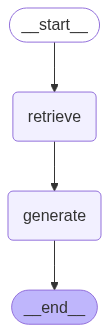

In [97]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Sample prompts to try
1. What is the salary of Aadhya Patel?
2. Tell me about the backend architecture?
3. Tell me about Myra Garg and how many leaves she has remaining?

In [104]:
result = graph.invoke(
    {"question": "What is the salary of Aadhya Patel?", "access_level": "c_level"})

# print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Answer: {'answer': "Aadhya Patel's salary is 1,332,478.37. Thanks for asking!", 'sources': ['hr_data.csv']}


Earlier it was challenging to populate the `sources` field by LLM but one shot prompting helped, by giving it one example on how exactly it can extract that data from prompt.